In [17]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
# Borra recursivamente las carpetas train, test y logs si existen
#!rm -rf train/
#!rm -rf test/
#!rm -rf logs/


In [19]:

from google.colab import files
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import TensorBoard

import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random


In [20]:
local_zip = './im_train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./train')
local_zip = './im_test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./test')
local_zip = './im_validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation')
zip_ref.close()

In [21]:
# We create an image generator with augmentation
train_datagen = ImageDataGenerator(
      # We scale pixels between 0 and 1
      rescale = 1./255,
      rotation_range = 30,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        # We define the directory where the training images are located.
        './train/',
        # We transform all images to 96 x 96.
        target_size=(96, 96),
        # We group the images into batches of 128.
        batch_size=128,
        # We specify that the images remain in color (RGB).
        color_mode="rgb",
        # We define a categorical class type.
        class_mode='categorical')

test_datagen = ImageDataGenerator(
    rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
        # We define the directory where the test images are located.
        './test',
        # We transform all images to 96 x 96.
        target_size = (96, 96),
        # We specify that the images remain in color (RGB).
        color_mode = "rgb",
        # We define a categorical class type.
        class_mode = 'categorical')
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/validation',  # carpeta con las imágenes de validación organizadas por clase
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=128,
    class_mode='categorical'
)


Found 442 images belonging to 7 classes.
Found 92 images belonging to 7 classes.
Found 103 images belonging to 7 classes.


In [22]:
# Creamos una carpeta para guardar los modelos entrenados
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
histories = []  #guardaremos accuracy, pérdida...
models = []     # guardaremos los modelos ya entrenados
log_dirs=[]     #guardaremos las rutas

In [23]:
#  Entrenamos los 3 modelos
kernel_sizes = [(5,5), (3,3), (3,3)]
pool_sizes = [(2,2), (2,2), (3,3)]
learning_rates = [0.01, 0.001, 0.0005]
dense_configs = [256, 128, 64]
epochs = [50, 50, 50]

input_size = 96
num_colors = 3

models = []
histories = []
log_dirs = []

for i in range(3):
    print(f"\nTraining model {i+1} with LR={learning_rates[i]}, Kernel={kernel_sizes[i]}, Pool={pool_sizes[i]}, Dense={dense_configs[i]}")
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(16, kernel_sizes[i], activation='relu', padding='same', input_shape=(input_size, input_size, num_colors)))
    model.add(keras.layers.MaxPooling2D(pool_sizes[i]))

    model.add(keras.layers.Conv2D(32, kernel_sizes[i], activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_sizes[i]))

    model.add(keras.layers.Conv2D(32, kernel_sizes[i], activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_sizes[i]))

    if i >= 1:
        model.add(keras.layers.Conv2D(64, kernel_sizes[i], activation='relu', padding='same'))
        model.add(keras.layers.MaxPooling2D(pool_sizes[i]))

    if i == 2:
        model.add(keras.layers.Conv2D(64, kernel_sizes[i], activation='relu', padding='same'))  # sin pooling final

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(dense_configs[i], activation='relu'))
    model.add(keras.layers.Dense(7, activation='softmax'))

    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rates[i])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    log_dir = os.path.join("logs", f"model_{i+1}")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

    # Entrenamos el modelo
    history = model.fit(train_generator, epochs=epochs[i], validation_data=val_generator, callbacks=[tensorboard_callback])

    # Guardamos el modelo entrenado
    models.append(model)
    histories.append(history)
    log_dirs.append(log_dir)







Training model 1 with LR=0.01, Kernel=(5, 5), Pool=(2, 2), Dense=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.1702 - loss: 351.9421 - val_accuracy: 0.3398 - val_loss: 9.3045
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3036 - loss: 7.4018 - val_accuracy: 0.1456 - val_loss: 1.9786
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1075 - loss: 1.9723 - val_accuracy: 0.1359 - val_loss: 1.9375
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.1352 - loss: 1.9331 - val_accuracy: 0.3107 - val_loss: 1.9147
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3479 - loss: 1.9056 - val_accuracy: 0.3398 - val_loss: 1.8957
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3751 - loss: 1.8816 - val_accuracy: 0.3398 - val_loss: 1.8760
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3634 - loss: 1.8624 - val_accuracy: 0.3398 - val_loss: 1.8568
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3616 - loss: 1.8391 - val_accuracy: 0.3398 - val_loss: 1.8397
Epoch 

In [24]:
# Comparamos métricas entre los 3 modelos
for i, hist in enumerate(histories):
    acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]

    print(f"\n Modelo {i+1} :")
    print(f" - Accuracy (train):       {acc:.3f}")
    print(f" - Loss (train):           {loss:.3f}")
    print(f" - Accuracy (validation):  {val_acc:.3f}")
    print(f" - Loss (validation):      {val_loss:.3f}")



 Modelo 1 :
 - Accuracy (train):       0.360
 - Loss (train):           1.787
 - Accuracy (validation):  0.340
 - Loss (validation):      1.813

 Modelo 2 :
 - Accuracy (train):       0.688
 - Loss (train):           0.838
 - Accuracy (validation):  0.573
 - Loss (validation):      0.970

 Modelo 3 :
 - Accuracy (train):       0.477
 - Loss (train):           1.412
 - Accuracy (validation):  0.485
 - Loss (validation):      1.409


In [25]:
#Seleccionamos manualmente el índice del mejor modelo (0, 1 o 2) según la justificación previa
best_index = 1
best_model = models[best_index]
best_history = histories[best_index]


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 891ms/step


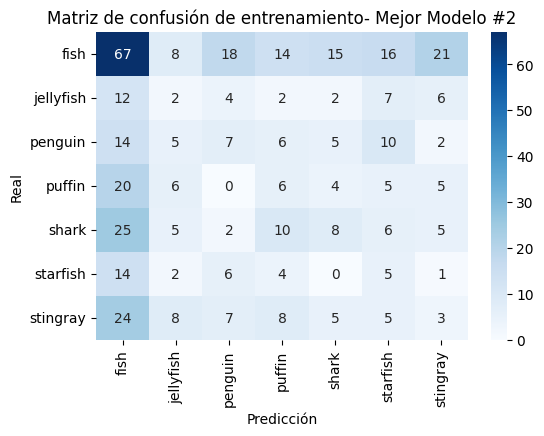

In [26]:
# Dibujamos la matriz de confusión del conjunto de entrenamiento del mejor modelo seleccionado.
y_pred_probs_train = best_model.predict(train_generator)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)
y_true_train = train_generator.classes
class_names = list(train_generator.class_indices.keys())

cm = confusion_matrix(y_true_train, y_pred_train)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Matriz de confusión de entrenamiento- Mejor Modelo #{best_index+1}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


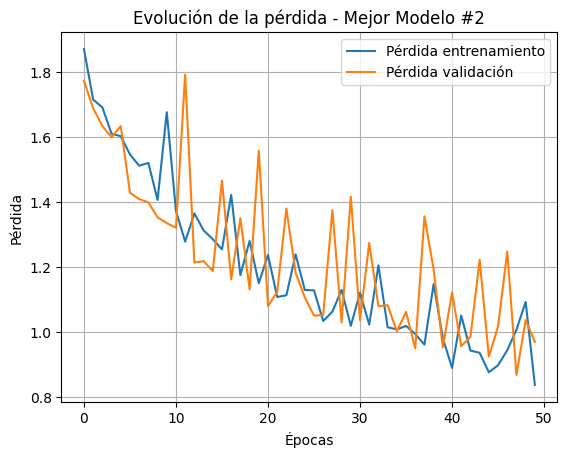

In [27]:
# Dibujamos un gráfico que muestra la variación de la pérdida en función de las épocas para el conjunto de entrenamiento del mejor modelo.
plt.plot(best_history.history['loss'], label='Pérdida entrenamiento')
plt.plot(best_history.history['val_loss'], label='Pérdida validación')
plt.title(f"Evolución de la pérdida - Mejor Modelo #{best_index+1}")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()



In [28]:
# Dibuja la arquitectura de red del mejor modelo
print(f"\n Arquitectura del mejor modelo ({best_index+1}):")
best_model.summary()


 Arquitectura del mejor modelo (2):


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 96, 96, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 48, 48, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 657,552 (2.51 MB)

 Trainable params: 328,775 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 328,777 (1.25 MB)